# How to user profiler in Jupyter Notebook


## Line Profiler
* [line-profiler](https://pypi.org/project/line-profiler/)
* [Easily Profile Python Code in Jupyter](https://mortada.net/easily-profile-python-code-in-jupyter.html)

## Memory Profiler

* [memory-profiler](https://pypi.org/project/memory-profiler/)
* [Profiling and Timing Code](https://jakevdp.github.io/PythonDataScienceHandbook/01.07-timing-and-profiling.html)

In [1]:
# !pip install line_profiler

In [12]:
import numpy as np
import pandas as pd

In [13]:
%load_ext line_profiler

In [14]:
origin = {'lat': 34, 'lon': -120}
np.random.seed(1)
n = 100000
changes = np.random.randn(n, 2) / 30
changes[0] = [0, 0]
trace = pd.DataFrame.from_records(changes, columns=['lat', 'lon']).cumsum()
trace['lat'] += origin['lat']
trace['lon'] += origin['lon']

trace.head()

,lat,lon
0,34.000000,-120.000000
1,33.982394,-120.035766
2,34.011241,-120.112484
3,34.069402,-120.137857
4,34.080036,-120.146169


Suppose you are interested in computing the maximum distance from the origin for the duration of the random walk. To compute distances between two points on Earth, we can use the haversine formula

In [5]:
from math import radians, cos, sin, asin, sqrt
def haversine(lat1, lon1, lat2, lon2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in lat/lon)
    """
    # convert to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * asin(sqrt(a))
    earth_radius = 6367
    distance_km = earth_radius * c
    return distance_km

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set()
import matplotlib as mpl
mpl.rcParams['axes.formatter.useoffset'] = False

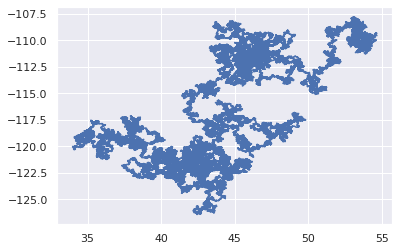

In [7]:
plt.plot(trace.lat, trace.lon)

In [17]:
def get_distances(trace, origin):
    distances = {}
    for i in trace.index:
        distances[i] = haversine(trace['lat'].loc[i], trace['lon'].loc[i], origin['lat'], origin['lon'])
    distances = pd.Series(distances)
    return distances

def get_farthest(trace, origin):
    distance = get_distances(trace, origin)
    max_idx = distance.argmax()
    return trace.loc[max_idx], distance.loc[max_idx]

In [9]:
get_farthest(trace, origin)

(lat     54.648484
 lon   -109.343278
 Name: 97647, dtype: float64,
 2439.5707960599893)

# Line Profiling

Profile the specific function ```function_to_profile``` during the execution of ```function_to_execute```.

```lprun -f <function_to_profile> <function_to_execute>```

In [10]:
%lprun -f get_farthest get_farthest(trace, origin)

The distance computation get_distances() is the hot spot. We can then further analyze get_distances().
```
Timer unit: 1e-06 s

Total time: 9.19339 s     <----- Total time spent in get_farthest function
File: /tmp/ipykernel_8077/3270931704.py
Function: get_farthest at line 8

Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
     8                                           def get_farthest(trace, origin):
     9         1    9191162.0 9191162.0    100.0      distance = get_distances(trace, origin)  <----------
    10         1        591.0    591.0      0.0      max_idx = distance.argmax()
    11         1       1634.0   1634.0      0.0      return trace.loc[max_idx], distance.loc[max_idx]
```

In [11]:
%lprun -f get_distances  get_farthest(trace, origin)

The loop with the haversine() computation is the hot spot.

```
Timer unit: 1e-06 s

Total time: 9.44974 s     <----- Total time spent in get_distances
File: /tmp/ipykernel_8077/3270931704.py
Function: get_distances at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
     1                                           def get_distances(trace, origin):
     2         1          2.0      2.0      0.0      distances = {}
     3    100001      89401.0      0.9      0.9      for i in trace.index:
     4    100000    9322398.0     93.2     98.7          distances[i] = haversine(trace['lat'].loc[i], trace['lon'].loc[i], origin['lat'], origin['lon'])   <---------- 
     5         1      37938.0  37938.0      0.4      distances = pd.Series(distances)
     6         1          2.0      2.0      0.0      return distances
```

In [12]:
%lprun -f haversine  get_farthest(trace, origin)

haversine itself only taks 8% of the total exec time. This suggests that the expensive part is not actually within haversine() itself, but the loop around it.


```
Timer unit: 1e-06 s

Total time: 0.742353 s   <---- Total time spent in haversine is about 8% of the total execution time (approx 9 sec)
File: /tmp/ipykernel_8077/2607183205.py
Function: haversine at line 2

Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
     2                                           def haversine(lat1, lon1, lat2, lon2):
     3                                               """
     4                                               Calculate the great circle distance between two points 
     5                                               on the earth (specified in lat/lon)
     6                                               """
     7                                               # convert to radians 
     8    100000     180514.0      1.8     24.3      lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
     9                                               # haversine formula
    10    100000      59866.0      0.6      8.1      dlon = lon2 - lon1
    11    100000      46578.0      0.5      6.3      dlat = lat2 - lat1
    12    100000     206491.0      2.1     27.8      a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    13    100000     113318.0      1.1     15.3      c = 2 * asin(sqrt(a))
    14    100000      43543.0      0.4      5.9      earth_radius = 6367
    15    100000      51416.0      0.5      6.9      distance_km = earth_radius * c
    16    100000      40627.0      0.4      5.5      return distance_km
```
    

The above example illustrates a key concept when using numpy and pandas known as vectorization. Essentially, we want to avoid writing loops in python, and instead **give numpy or pandas an entire "vector" (i.e. numpy array)** to work with. There are many excellent resources on this topic including [Modern Pandas](http://tomaugspurger.github.io/modern-4-performance.html) by Tom Augspurger, [Why Python is Slow](https://jakevdp.github.io/blog/2014/05/09/why-python-is-slow/) by Jake VanderPlas, and [Performance Pandas](https://www.youtube.com/watch?v=2RW9zSQF1Sk) by Jeff Reback.

In this example, vectorization means being able to **pass the entire lat/lon arrays** into the haversine() computation, instead of looping through one point at a time.

In [13]:
def haversine_vectorized(lat1, lon1, lat2, lon2):
    """
    Calculate the great circle distance between two points 
    on the earth. Note that lat1/lon1/lat2/lon2 can either be
    scalars or numpy arrays.
    """
    # convert to radians 
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    earth_radius = 6367
    distance_km = earth_radius * c
    return distance_km

In [14]:
def get_distances_vectorized(trace, origin):
    distances = haversine_vectorized(trace['lat'], trace['lon'], origin['lat'], origin['lon'])
    return distances

def get_farthest_vectorized(trace, origin):
    distance = get_distances_vectorized(trace, origin)
    max_idx = distance.argmax()
    return trace.loc[max_idx], distance.loc[max_idx]

In [15]:
%lprun -f get_farthest_vectorized get_farthest_vectorized(trace, origin)

```
Timer unit: 1e-06 s

Total time: 0.017262 s
File: /tmp/ipykernel_8077/2995855449.py
Function: get_farthest_vectorized at line 5

Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
     5                                           def get_farthest_vectorized(trace, origin):
     6         1      16413.0  16413.0     95.1      distance = get_distances_vectorized(trace, origin)
     7         1        422.0    422.0      2.4      max_idx = distance.argmax()
     8         1        427.0    427.0      2.5      return trace.loc[max_idx], distance.loc[max_idx]
```

In [16]:
%lprun -f get_distances_vectorized get_farthest_vectorized(trace, origin)

```
Timer unit: 1e-06 s

Total time: 0.016945 s
File: /tmp/ipykernel_8077/2995855449.py
Function: get_distances_vectorized at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
     1                                           def get_distances_vectorized(trace, origin):
     2         1      16943.0  16943.0    100.0      distances = haversine_vectorized(trace['lat'], trace['lon'], origin['lat'], origin['lon'])
     3         1          2.0      2.0      0.0      return distances
```

In [17]:
%lprun -f haversine_vectorized get_farthest_vectorized(trace, origin)

```
Timer unit: 1e-06 s

Total time: 0.016144 s
File: /tmp/ipykernel_8077/1698574348.py
Function: haversine_vectorized at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
     1                                           def haversine_vectorized(lat1, lon1, lat2, lon2):
     2                                               """
     3                                               Calculate the great circle distance between two points 
     4                                               on the earth. Note that lat1/lon1/lat2/lon2 can either be
     5                                               scalars or numpy arrays.
     6                                               """
     7                                               # convert to radians 
     8         1       2661.0   2661.0     16.5      lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
     9                                               # haversine formula 
    10         1        719.0    719.0      4.5      dlon = lon2 - lon1
    11         1        659.0    659.0      4.1      dlat = lat2 - lat1
    12         1       9066.0   9066.0     56.2      a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    13         1       2599.0   2599.0     16.1      c = 2 * np.arcsin(np.sqrt(a)) 
    14         1          2.0      2.0      0.0      earth_radius = 6367
    15         1        437.0    437.0      2.7      distance_km = earth_radius * c
    16         1          1.0      1.0      0.0      return distance_km
```

# Memory Profiler


* [memory-profiler](https://pypi.org/project/memory-profiler/)

> The memory profiler extension contains two useful magic functions: the %memit magic (which offers a memory-measuring equivalent of %timeit) and the %mprun function (which offers a memory-measuring equivalent of %lprun). 
> 


In [1]:
%load_ext memory_profiler

In [19]:
%memit get_farthest(trace, origin)

peak memory: 188.23 MiB, increment: 5.79 MiB


> Unfortunately, this magic works only for functions defined in separate modules rather than the notebook itself, so we'll start by using the %%file magic to create a simple module called mprun_demo.py, which contains our sum_of_lists function, with one addition that will make our memory profiling results more clear:

In [18]:
%%file mprun_demo.py
def sum_of_lists(N):
    total = 0
    for i in range(5):
        L = [j ^ (j >> i) for j in range(N)]
        total += sum(L)
        del L # remove reference to L
    return total

Writing mprun_demo.py


In [19]:
from mprun_demo import sum_of_lists
%mprun -f sum_of_lists sum_of_lists(1000000)

```
Filename: /home/oonisim/home/repository/git/oonisim/python-programs/jupyter/mprun_demo.py

Line #    Mem usage    Increment  Occurrences   Line Contents
=============================================================
     1    137.1 MiB    137.1 MiB           1   def sum_of_lists(N):
     2    137.1 MiB      0.0 MiB           1       total = 0
     3    144.9 MiB      0.0 MiB           6       for i in range(5):
     4    175.7 MiB -47820904.1 MiB     5000015           L = [j ^ (j >> i) for j in range(N)]
     5    175.7 MiB     -0.6 MiB           5           total += sum(L)
     6    144.9 MiB   -130.6 MiB           5           del L # remove reference to L
     7    144.9 MiB      0.0 MiB           1       return total
```
